**author: jarvis yuan**

# SoCal EV/PHEV charging stations and street network analysis

In [76]:
import pandas as pd
import numpy as np
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import os
from scipy import stats
import haversine as hs
from shapely import geometry
import collections
from haversine import haversine, Unit
import contextily as cx

In [2]:
os.chdir('/Users/jarvis/Desktop/CE 88/project/data')
os.getcwd()

'/Users/jarvis/Desktop/CE 88/project/data'

# extract roadway network with osmnx

## extract from bonding box on entire SoCal region

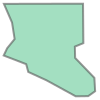

In [3]:
bbox = [[-117.780360058,33.3834315757], [-118.2254136354,33.6270330842],
        [-118.4992028028,33.7524390501], [-118.5306597501,33.8702505871],
        [-118.8714719564,34.0016338706], [-118.8188845665,34.1118843391],
        [-118.7057865411,34.2508358116], [-118.7449038774,34.5004071652],
        [-118.8681996614,34.7840823241], [-117.669498995,34.7864790651],
        [-117.6645851881,34.1891744165], [-117.7930683643,34.1363620016],
        [-117.7893132717,33.9653145708], [-117.4975264818,33.6624559519],
        [-117.4861431867,33.4605582062], [-117.5918570906,33.385975796],
        [-117.780360058,33.3834315757]]

bbox_points = []
for p in bbox:
    bbox_points += [geometry.Point(p[0], p[1])]

poly = geometry.Polygon([[p.x, p.y] for p in bbox_points])
poly

In [4]:
#cf = '["highway"~"motorway|primary"]'
#G = ox.graph_from_polygon(poly, network_type='drive', custom_filter=cf)

## loading saved network

In [5]:
# ox.io.save_graphml(G, '/Users/jarvis/Desktop/CE 88/project/socal_street_network')
G = ox.io.load_graphml('/Users/jarvis/Desktop/CE 88/project/data/socal_street_network.graphml')

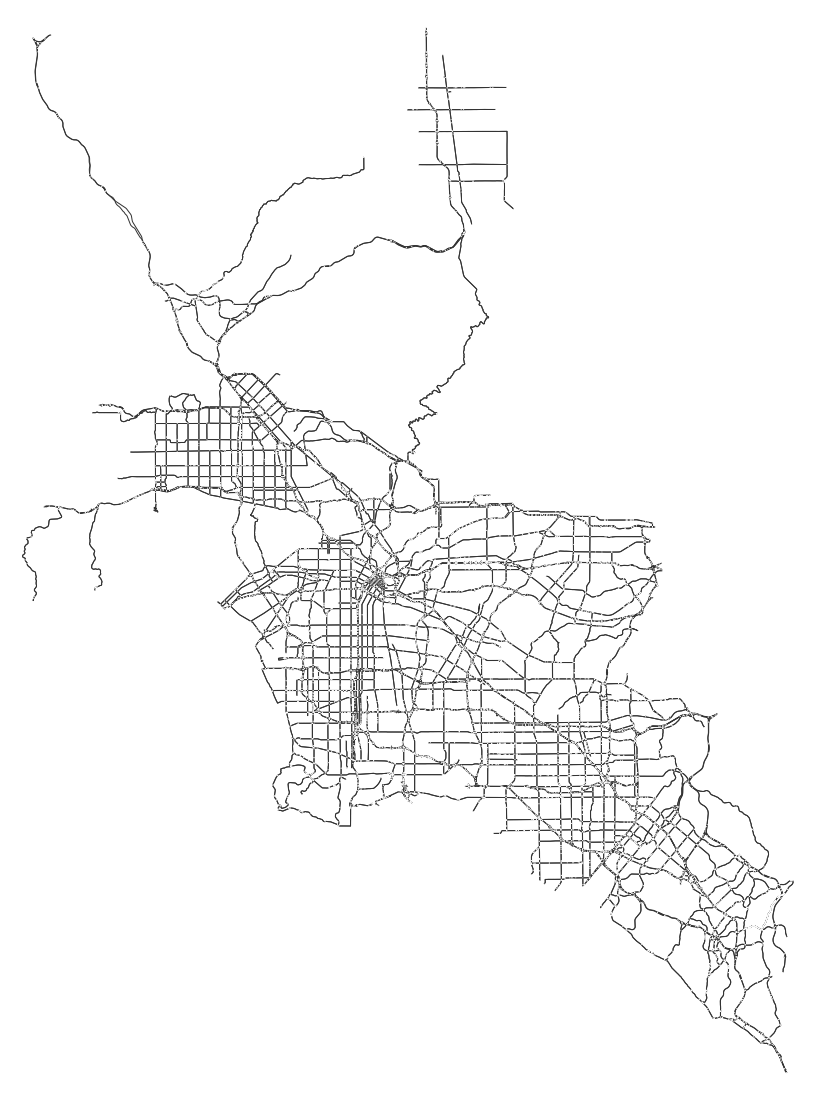

In [6]:
fig, ax = ox.plot_graph(G, 
                        bgcolor="#FFFFFF", edge_color="#333333", node_color="white", 
                        node_size=1, 
                        figsize=(20, 20))

In [7]:
G_proj = ox.project_graph(G)
nodes_proj = ox.graph_to_gdfs(G, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
print('network area = ', graph_area_m)
ox.basic_stats(G, area=graph_area_m, clean_intersects=True, circuity_dist='euclidean')

network area =  1.078684939277267


/Users/jarvis/opt/anaconda3/envs/geo_env/lib/python3.8/site-packages/osmnx/simplification.py:450: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  chunks = get_chunks(gs_nodes.loc[idx].buffer(tolerance).values, n)
/Users/jarvis/opt/anaconda3/envs/geo_env/lib/python3.8/site-packages/osmnx/simplification.py:399: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return _merge_nodes_geometric(G, tolerance).centroid


{'n': 14198,
 'm': 24089,
 'k_avg': 3.393294830257783,
 'intersection_count': 12581,
 'streets_per_node_avg': 2.9068178616706577,
 'streets_per_node_counts': {0: 0,
  1: 1617,
  2: 670,
  3: 9488,
  4: 2298,
  5: 99,
  6: 22,
  7: 1,
  8: 3},
 'streets_per_node_proportion': {0: 0.0,
  1: 0.11388928018030708,
  2: 0.047189745034511905,
  3: 0.6682631356529088,
  4: 0.1618537822228483,
  5: 0.006972813072263699,
  6: 0.0015495140160585999,
  7: 7.04324552753909e-05,
  8: 0.0002112973658261727},
 'edge_length_total': 11214603.715000046,
 'edge_length_avg': 465.5487448628024,
 'street_length_total': 9421587.524999978,
 'street_length_avg': 453.8992881919342,
 'street_segments_count': 20757,
 'node_density_km': 13162323383.798096,
 'intersection_density_km': 11663275848.116907,
 'edge_density_km': 10396551677558.396,
 'street_density_km': 8734327496323.964,
 'circuity_avg': 104795.48482544592,
 'self_loop_proportion': 8.302544729959733e-05,
 'clean_intersection_count': 1,
 'clean_intersecti

## simple centrality analysis experiment

# EV/PHEV charging stations data 

In [8]:
colns = ['ID', 'AddressInfo_Postcode', 'AddressInfo_Latitude', 'AddressInfo_Longitude', 
         'Connections_0_LevelID', 'DateCreated']
chargers = pd.read_csv('charging_stations_la.csv')[colns]
chargers = gpd.GeoDataFrame(chargers, geometry=gpd.points_from_xy(chargers.AddressInfo_Longitude, 
                                                                  chargers.AddressInfo_Latitude))
chargers.dropna(inplace=True)
chargers.reset_index(drop=True, inplace=True)
chargers.drop(['AddressInfo_Latitude', 'AddressInfo_Longitude'], axis=1, inplace=True)
chargers['Connections_0_LevelID'] = chargers['Connections_0_LevelID'].astype(int)
chargers.head()

,ID,AddressInfo_Postcode,Connections_0_LevelID,DateCreated,geometry
0,139561,90241,2,2019-12-24T09:11:00Z,POINT (-118.13679 33.95245)
1,4841,90241,2,2011-07-04T18:02:00Z,POINT (-118.14548 33.94630)
2,75793,90723,2,2016-12-23T01:25:00Z,POINT (-118.13371 33.94175)
3,121989,90241,2,2019-04-06T05:02:00Z,POINT (-118.15117 33.94730)
4,139551,90241,2,2019-12-24T09:11:00Z,POINT (-118.12922 33.94080)


In [9]:
chargers.dtypes

ID                          int64
AddressInfo_Postcode       object
Connections_0_LevelID       int64
DateCreated                object
geometry                 geometry
dtype: object

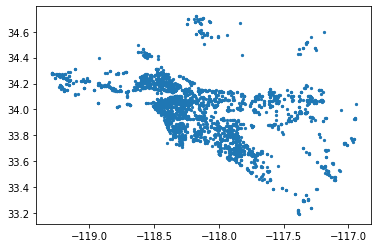

In [10]:
chargers.plot(markersize = 5);

## filtering the stations within bbox

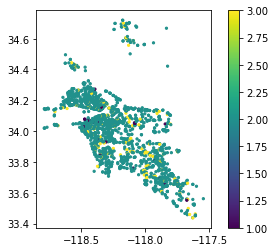

In [138]:
chargers_socal = chargers.loc[chargers.within(poly)]
chargers_socal.reset_index(drop=True, inplace=True)
chargers_socal = chargers_socal.set_crs(epsg=4326)
chargers_socal.plot(markersize = 5, column = 'Connections_0_LevelID', legend = True);

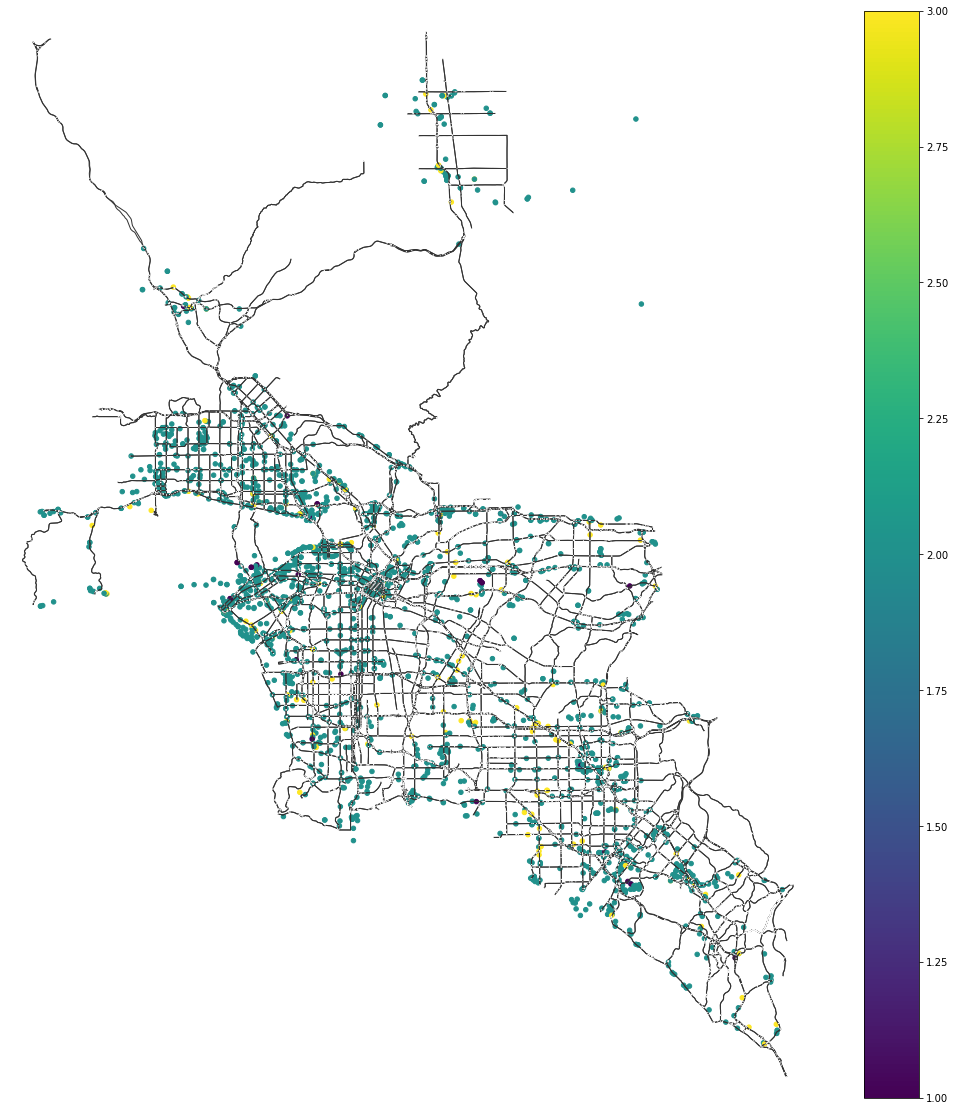

In [12]:
figure, ax = plt.subplots(figsize=(20, 20))
chargers_socal.plot(ax=ax, markersize = 20, column = 'Connections_0_LevelID', legend = True);
ox.plot_graph(G, ax=ax, bgcolor="#FFFFFF", edge_color="#333333", node_color="white", node_size=1);

## finding all nearest nodes to the EV chargers

In [13]:
nearest_node_ids = []

for index, row in chargers_socal.iterrows():
    ev_node = (row['geometry'].y, row['geometry'].x)
    nearest_node_ids.append(ox.get_nearest_node(G, ev_node)) # lat, lon

In [14]:
nearest_node_ids[0:10]

[123043863,
 4060459501,
 123062150,
 1841934729,
 5968243481,
 4013453669,
 4013453669,
 5968243481,
 2897567426,
 4013453669]

## adding ev charging stations as nodes to the street network

In [15]:
# all nodes id in the road network
node_ids = list(G.nodes)
G.nodes[node_ids[20]]

{'y': 33.6869038,
 'x': -117.8727921,
 'ref': '5B',
 'highway': 'motorway_junction',
 'street_count': 3}

In [16]:
type(node_ids[0]), type(chargers_socal.loc[0]['ID'])

(int, numpy.int64)

- checking the number of duplidate node ids with EV charger IDs

In [17]:
num_dup_ids = 0
for index, row in chargers_socal.iterrows():
    if row['ID'] in node_ids:
        num_dup_ids += 1
        print(row['ID'])
num_dup_ids # no duplidates, good

0

- adding EV chargers as nodes 

In [18]:
for index, row in chargers_socal.iterrows():
    G.add_node(row['ID'], y=row['geometry'].y, x=row['geometry'].x, ev_charger='yes')

In [19]:
# testing 
G.nodes[139561]

{'y': 33.9524511, 'x': -118.136794, 'ev_charger': 'yes'}

## adding edges from EV charger nodes to its nearest neighbor node

OSMnx automatically uses edge lengths as the weight when calculating betweenness centrality. For any further customization, you can just call `nx.betweenness_centrality(G)` directly on your OSMnx graph object, and parameterize it as desired.

In [20]:
nx.is_weighted(G) # the default street network is not weighted, ignore when adding edges

False

In [21]:
G.get_edge_data(14840398, 1846221722) 
# length in meters

{0: {'osmid': [32150984, 838991814, 32150983],
  'oneway': True,
  'lanes': '6',
  'ref': 'I 5',
  'name': 'Santa Ana Freeway',
  'highway': 'motorway',
  'maxspeed': '65 mph',
  'length': 544.998,
  'bridge': 'yes',
  'geometry': <shapely.geometry.linestring.LineString at 0x7fb4420a1f40>,
  'edge_centrality': '0.01427434863840601'}}

In [22]:
chargers_socal.shape

(2555, 5)

In [23]:
# use the parsed array of nearest node ids in the street network to connect to as new edges. 
for index, row in chargers_socal.iterrows():
    ev_node = (row['geometry'].x, row['geometry'].y)
    ev_node_id = row['ID']
    
    node_id = nearest_node_ids[index]
    nx_node = (G.nodes[node_id]['x'], G.nodes[node_id]['y'])
    
    length = hs.haversine(ev_node, nx_node, unit=Unit.METERS)
    G.add_edge(ev_node_id, node_id, key=row['ID'], length=length) # use EV charger ID as edge key

---

## plot the appended network

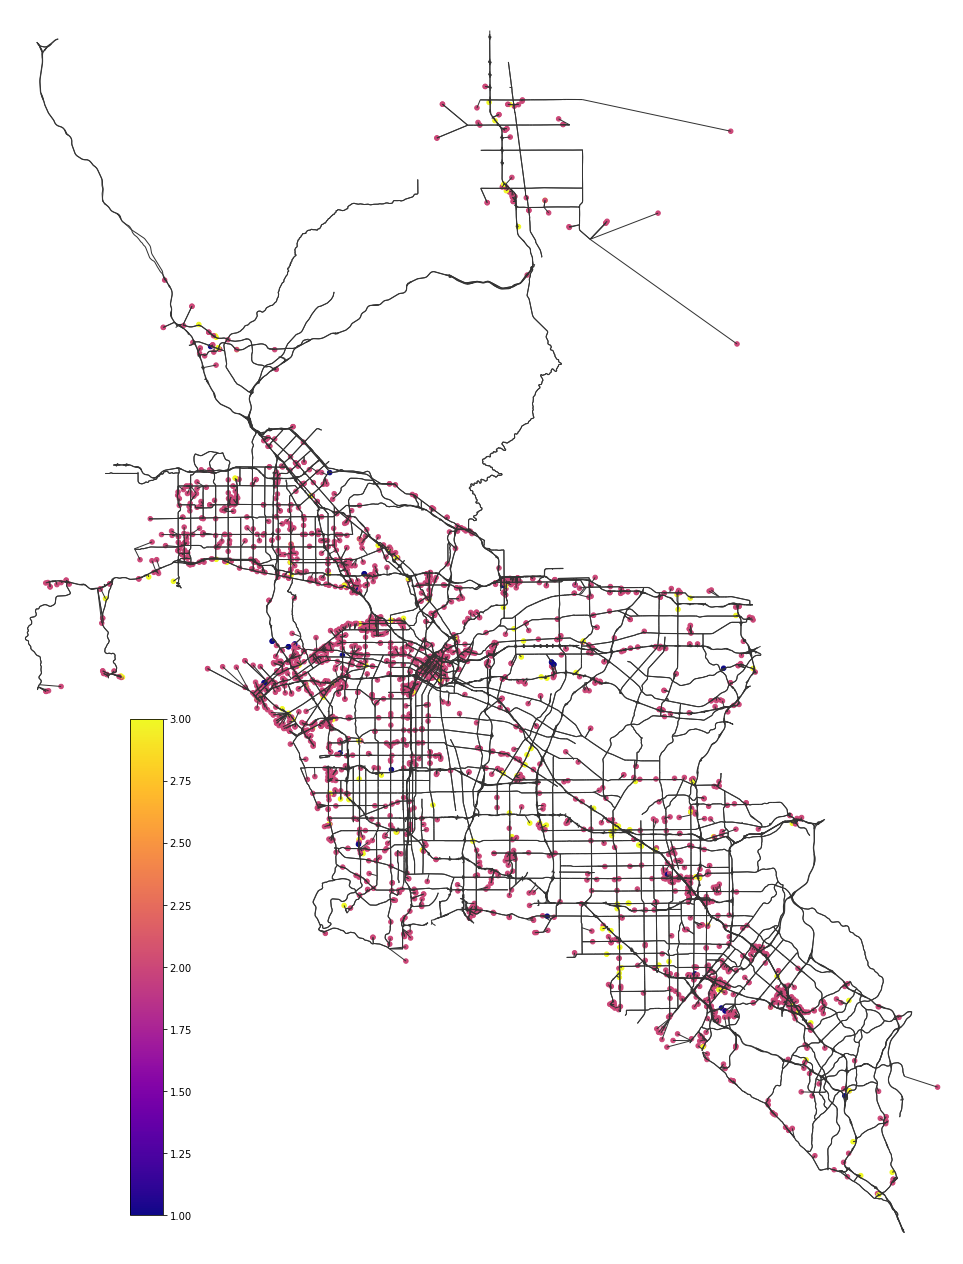

In [26]:
fig, ax = plt.subplots(figsize=(23, 23))

cax = fig.add_axes([0.3, 0.15, 0.02, 0.3])
sm = plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=1, vmax=3))
cbr = fig.colorbar(sm, cax=cax)
cbr.ax.tick_params(labelsize=10)

chargers_socal.plot(ax=ax, markersize = 20, column = 'Connections_0_LevelID', legend = False, alpha=1, cmap='plasma');
ox.plot_graph(G, ax=ax, bgcolor="#FFFFFF", edge_color="#333333", node_color="white", node_size=0);

In [25]:
# write to save appended network, run only once
#os.getcwd()
#ox.save_graphml(G, 'socal_street_network_w_chargers.graphml')

# assignment 3

In [28]:
nx.average_shortest_path_length(G)

51.61825509263163

node degree historgam 

/Users/jarvis/opt/anaconda3/envs/geo_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


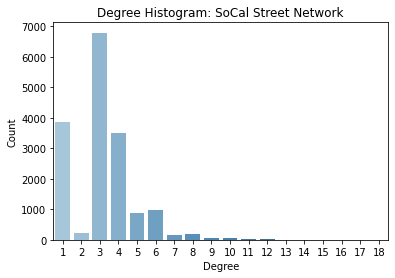

In [37]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

ax = sns.barplot(list(deg), list(cnt), palette="Blues_d")

plt.title("Degree Histogram: SoCal Street Network")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.show()

shortest path distribution using physical length as weights

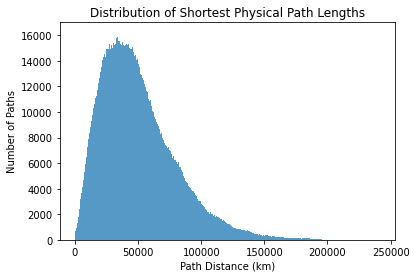

In [38]:
lengths = nx.shortest_path_length(G, weight='length')
plengths=[]
for key in lengths:   #iterates all the lengths
   ll = key
   for i in list(ll[1].values()):    #saves a list with the lengths greater than zero
      if i > 0:
        plengths.append(i)

sns.histplot(x=plengths, binwidth=5);
plt.xlabel("Path Distance (km)");
plt.ylabel("Number of Paths");
plt.title("Distribution of Shortest Physical Path Lengths");

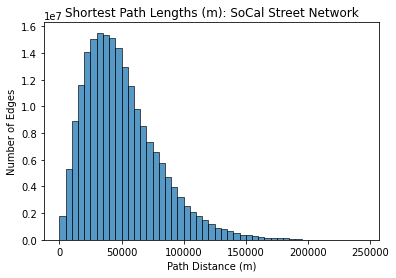

In [45]:
sns.histplot(x=plengths, binwidth=5000);
plt.xlabel("Path Distance (m)");
plt.ylabel("Number of Edges");
plt.title("Shortest Path Lengths (m): SoCal Street Network");

shortest path distribution

In [ ]:
lengths = nx.shortest_path_length(G)
plengths=[]
for key in lengths:   #iterates all the lengths
   ll = key
   for i in list(ll[1].values()):    #saves a list with the lengths greater than zero
      if i > 0:
        plengths.append(i)

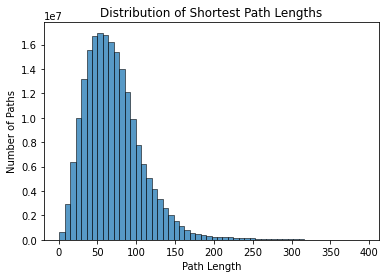

In [51]:
sns.histplot(x=plengths, binwidth=7);
plt.xlabel("Path Length");
plt.ylabel("Number of Paths");
plt.title("Distribution of Shortest Path Lengths");

In [46]:
H = nx.DiGraph(G)
H

In [48]:
nx.average_clustering(H)

0.026920664639611288

## small world?

In [53]:
num_nodes = H.number_of_nodes()
num_edges = H.number_of_edges()
c = nx.average_clustering(H)
k = np.mean(list(dict(H.degree()).values()))
l = nx.average_shortest_path_length(H)
n = int(num_nodes)

In [64]:
n, num_edges, k, l

(16753, 26032, 3, 51.61825509263163)

In [60]:
k_int = int(np.mean(list(dict(H.degree()).values())))

In [68]:
watts_strogatz_c0 = nx.watts_strogatz_graph(n, k_int, 0)
print("C(0) =" , nx.average_clustering(watts_strogatz_c0))

c_0 = nx.average_clustering(watts_strogatz_c0)+0.001

c_p = nx.average_clustering(H)
p = -(c_p/c_0)**(1/3)+1

print(n, k, p)
watts_strogatz = nx.watts_strogatz_graph(n, k, p, seed=123)

C(0) = 0.0
16753 3 -1.9970587706512823


In [70]:
watts_strogatz = nx.watts_strogatz_graph(n, k, 0.5, seed=123)

In [ ]:
num_nodes_ws = watts_strogatz.number_of_nodes()
num_edges_ws = watts_strogatz.number_of_edges()
c_ws = nx.average_clustering(watts_strogatz)
k_ws = np.mean(list(dict(watts_strogatz.degree()).values()))
l_ws = nx.average_shortest_path_length(watts_strogatz)

In [72]:
socal = ['SoCal Street Network', num_nodes, num_edges, c, k, l]
ws = ['Small World Network Model', num_nodes_ws, num_edges_ws, c_ws, k_ws, l_ws]
df = pd.DataFrame(columns =['network', '#nodes', '#links', '<C>', '<K>', '<L>'])
df.loc[0] = socal
df.loc[1] = ws
df.set_index('network')

,#nodes,#links,<C>,<K>,<L>
network,,,,,
SoCal Street Network,16753,26032,0.026921,3,51.618255
Small World Network Model,16753,16753,0.000000,2.0,192.015645


---

# exploration

## contextily

In [80]:
nightlights = cx.providers.NASAGIBS.ViirsEarthAtNight2012
CA = cx.Place("California", source=nightlights)

<AxesSubplot:title={'center':'California, United States'}, xlabel='X', ylabel='Y'>

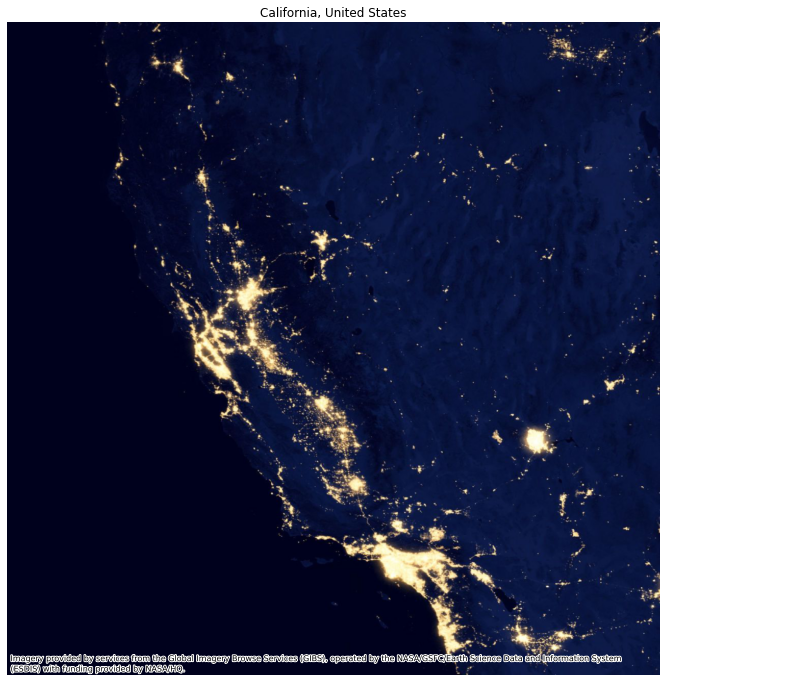

In [81]:
CA.plot()

In [127]:
w, s, e, n = -118.793825, 33.311935, -117.592195, 34.507458
socal_basemap, socal_extent = cx.bounds2img(w, s, e, n, zoom=9, ll=True, 
                                                    source=cx.providers.CartoDB.Positron)

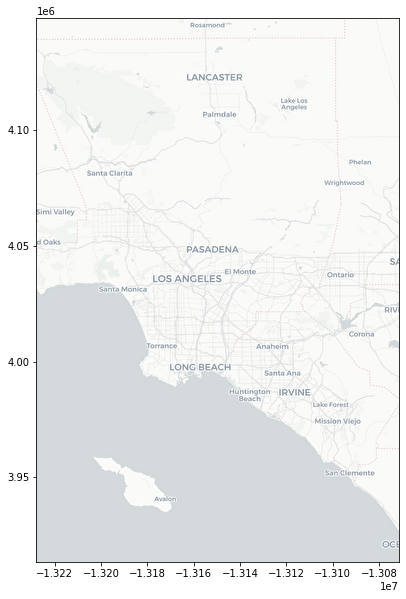

In [131]:
f, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(socal_basemap, extent=socal_extent, interpolation='sinc');
#ax.set_axis_off()

## cx.add_basemap

In [140]:
chargers_socal.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [149]:
chargers_socal.crs.to_string()

'EPSG:4326'

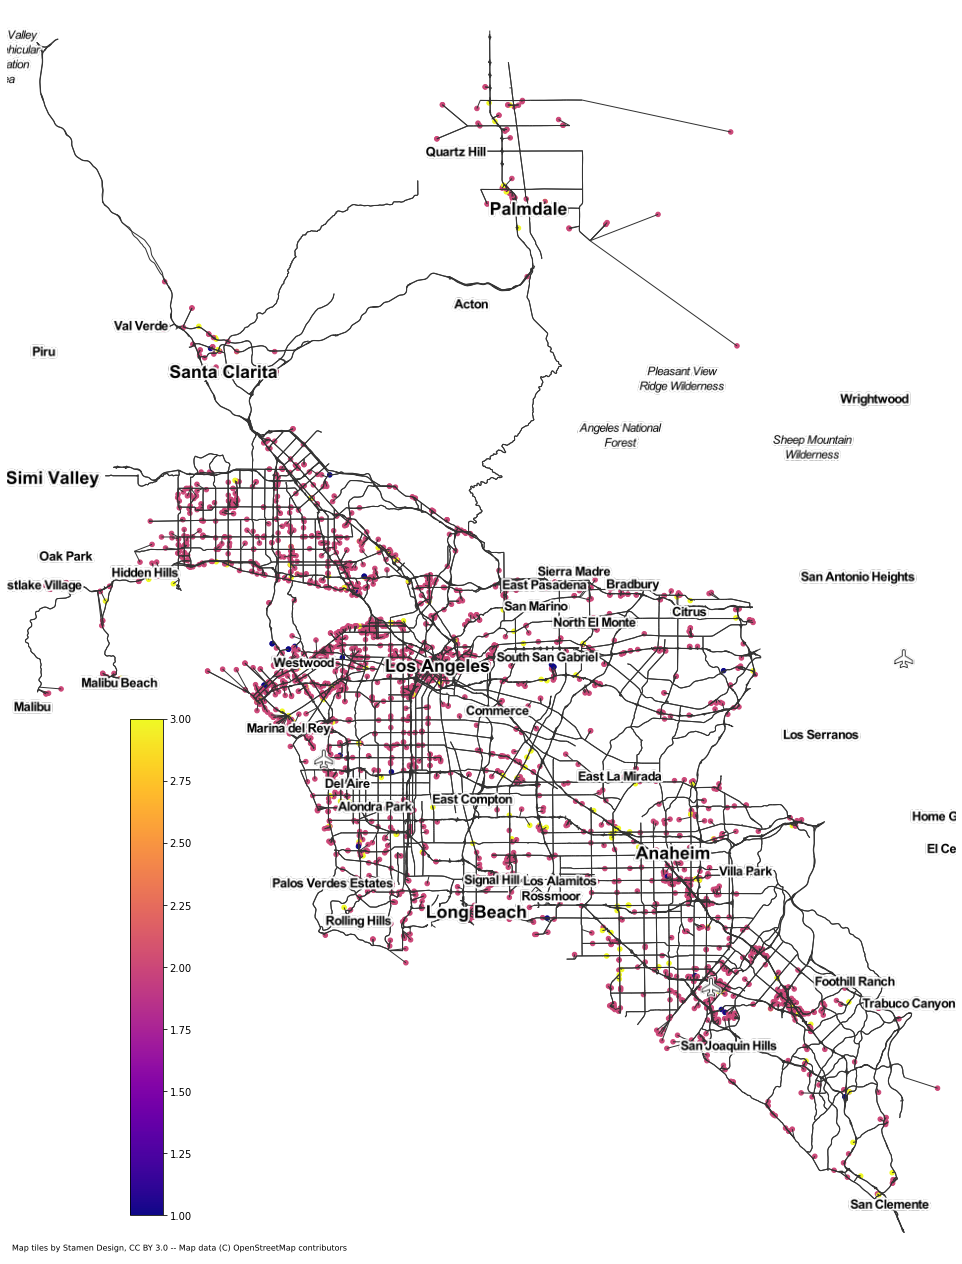

In [176]:
fig, ax = plt.subplots(figsize=(23, 23))

cax = fig.add_axes([0.3, 0.15, 0.02, 0.3])
sm = plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=1, vmax=3))
cbr = fig.colorbar(sm, cax=cax)
cbr.ax.tick_params(labelsize=10)

# convert crs to web mercator
chargers_socal_wm = chargers_socal.to_crs(epsg=3857)
G_wm = ox.project_graph(G, to_crs='EPSG:3857')


chargers_socal_wm.plot(ax=ax, markersize=20, column='Connections_0_LevelID', legend=False, alpha=1, cmap='plasma');
cx.add_basemap(ax, zoom=10, source=cx.providers.Stamen.TonerLabels);
ox.plot_graph(G_wm, ax=ax, edge_color="#333333", node_color="white", node_size=0);
#cx.add_basemap(ax, zoom=9, source=cx.providers.Stamen.Watercolor);

ax.set_axis_off()